## Modelo de Fijación de Precios de Activos de Capital (CAPM)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import jarque_bera
import cvxpy as cp
from cvxopt import matrix, solvers
import requests
import json
import urllib3
urllib3.disable_warnings()
from datetime import datetime
import pytz

Este cuaderno está dedicado a explorar algunos aspectos del modelo de valoración de activos de capital (CAPM) utilizando Python. Según CAPM, el rendimiento esperado de una inversión particular $E[r_{a}]$ viene dada por la siguiente ecuación:
$$
E[r_{a}] = r_{f} + \beta_{a}(E[r_{m}]-r_{f})\,,
$$
donde $r_{f}$ es el rendimiento libre de riesgo (como los rendimientos de los bonos del gobierno), $E[r_{m}]$ es el rendimiento esperado del mercado, generalmente medido por el rendimiento de algún índice como el S&P 500, y $\beta_{a}$ mide la volatilidad de la inversión con respecto al mercado, y formalmente viene dada por:
$$
\beta_{a} = \frac{\text{Cov}(r_{a},r_{m})}{\text{Var}(r_{m})}\,.
$$
Así, el modelo asume una relación lineal entre $E[r_{a}]$ y la cantidad $(E[r_{m}]-r_{f})$, también llamada prima de mercado, que está mediada por la coeficiente $\beta_{a}$. Si quisiéramos medir todos los rendimientos del modelo con respecto a la tasa libre de riesgo $r_{f}$ y así construir una regresión lineal entre las cantidades $(E[r_{a}]-r_{f})$ y la prima de mercado $(E[r_{a}]-r_{f})$, se debe plantear esta relación como:
$$
(E[r_{a}]-r_{f}) = \alpha + \beta_{a}(E[r_{m}]-r_{f})\,.
$$
De esta manera, $\alpha$ mide la diferencia entre el rendimiento esperado $E[r_{a}]$ medido en la vida real y el rendimiento esperado de nuestra inversión según el CAPM:
$$
\alpha = E[r_{a}] - \left( r_{f} +\beta_{a}(E[r_{m}]-r_{f})\right)\,.
$$

In [105]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

In [106]:
# Cargar el DataFrame
df = pd.read_csv('/Users/juanpablomigani/Desktop/Trabajo final Diplomatura/Trabajo/Datos/Datos.csv')

In [107]:
df

,Date,ALUA,BBAR,BMA,BYMA,CEPU,COME,CRES,EDN,GGAL,...,LOMA,MIRG,PAMP,TECO2,TGNO4,TGSU2,TRAN,TXAR,VALO,YPFD
0,2024-08-23,896.0,4115.00,6830.00,303.0,1130.00,251.50,989.00,1145.00,4425.00,...,1790.00,19000.0,2650.00,1810.00,2880.0,4730.00,1535.0,868.00,333.00,27200.00
1,2024-08-22,912.0,4050.00,6850.00,295.5,1120.00,246.50,972.00,1140.00,4240.00,...,1750.00,18900.0,2615.00,1800.00,2820.0,4755.00,1555.0,883.00,335.50,26850.00
2,2024-08-21,891.0,4315.00,7260.00,310.5,1175.00,242.00,981.00,1190.00,4365.00,...,1800.00,18950.0,2660.00,1905.00,2905.0,4815.00,1605.0,866.00,340.00,27500.00
3,2024-08-20,914.0,4435.00,7430.00,323.0,1200.00,244.25,1010.00,1215.00,4505.00,...,1825.00,18975.0,2715.00,1935.00,2950.0,5020.00,1635.0,886.00,332.00,28175.00
4,2024-08-19,916.0,4395.00,7360.00,320.0,1185.00,238.75,1025.00,1165.00,4425.00,...,1800.00,19000.0,2705.00,1985.00,2945.0,4955.00,1630.0,888.00,341.00,27925.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,2022-07-06,88.0,201.00,308.00,1445.0,81.35,12.70,126.70,56.45,186.50,...,288.85,3122.5,220.00,247.00,80.5,272.25,54.4,122.25,41.85,866.80
521,2022-07-05,88.0,215.15,301.55,1310.0,78.90,11.95,124.00,55.00,184.25,...,264.15,3065.5,216.50,239.15,81.8,266.00,53.4,119.00,39.70,857.00
522,2022-07-04,86.6,205.00,287.00,1300.0,74.40,11.35,122.50,54.75,176.25,...,259.15,3083.0,214.05,229.90,80.7,265.80,52.6,119.00,37.85,844.45
523,2022-07-01,84.6,202.75,290.30,1243.0,75.10,11.55,126.00,54.85,178.00,...,256.90,3110.0,215.00,232.00,83.9,264.25,53.0,118.25,37.60,842.00


Usaremos ^GSPC para calcular $E[r_{m}]$ y estableceremos $r_f = 0$, por simplicidad. Apliquemos entonces el CAPM a las acciones de. Para captar menos ruido en nuestra construcción, nos centraremos en los rendimientos mensuales.

In [108]:
# Seleccionar las acciones y el mercado del dataframe
stock_a = df['YPFD']  # Activo individual
stock_m = df['GGAL']  # Mercado proxy

# Asegurar que los datos están ordenados por fecha
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Filtrar el rango de fechas, si es necesario
start = pd.to_datetime('2022-06-30')
end = pd.to_datetime('2024-08-01')
filtered_df = df[(df['Date'] >= start) & (df['Date'] <= end)]

# Extraer los datos ajustados para las fechas seleccionadas
data_a = filtered_df['YPFD']
data_m = filtered_df['GGAL']

In [109]:
data_a.head()

524    838.90
523    842.00
522    844.45
521    857.00
520    866.80
Name: YPFD, dtype: float64

Nos centramos ahora en los rendimientos mensuales:

In [110]:
# Asegurarnos de que estamos trabajando con el DataFrame correcto
df['Date'] = pd.to_datetime(df['Date'])  # Convertir a datetime si no se ha hecho aún
filtered_df = df[(df['Date'] >= start) & (df['Date'] <= end)].copy()  # Asegurar copia para no afectar el original

# Convertir la columna de fecha a índice de fecha para resampling
filtered_df.set_index('Date', inplace=True)

# Obtener los últimos precios de cada mes utilizando 'ME' para month-end
M_stock_a = filtered_df['YPFD'].resample('ME').last()
M_stock_m = filtered_df['GGAL'].resample('ME').last()

# Crear un DataFrame con los datos resampleados
data = pd.DataFrame({'Inv_Close': M_stock_a, 'Markt_Close': M_stock_m})

# Mostrar las primeras filas del DataFrame resultante
data.head()

,Inv_Close,Markt_Close
Date,,
2022-06-30,838.90,177.10
2022-07-31,1124.95,229.95
2022-08-31,1610.00,239.65
2022-09-30,1925.50,231.80
2022-10-31,2377.00,238.50


Y ahora calculamos los retornos del registro:

In [111]:
# Calcular los retornos logarítmicos de los precios mensuales
data[['Inv_Ret', 'Markt_Ret']] = np.log(data[['Inv_Close', 'Markt_Close']] / data[['Inv_Close', 'Markt_Close']].shift(1))

# Eliminar filas con valores NaN generados por el shift
data.dropna(inplace=True)

# Mostrar las primeras filas del DataFrame resultante con los retornos
data.head()

,Inv_Close,Markt_Close,Inv_Ret,Markt_Ret
Date,,,,
2022-07-31,1124.95,229.95,0.293402,0.261147
2022-08-31,1610.00,239.65,0.358496,0.041318
2022-09-30,1925.50,231.80,0.178951,-0.033305
2022-10-31,2377.00,238.50,0.210654,0.028494
2022-11-30,2800.00,258.90,0.163780,0.082073


El diagrama de dispersión de los rendimientos se ve así:

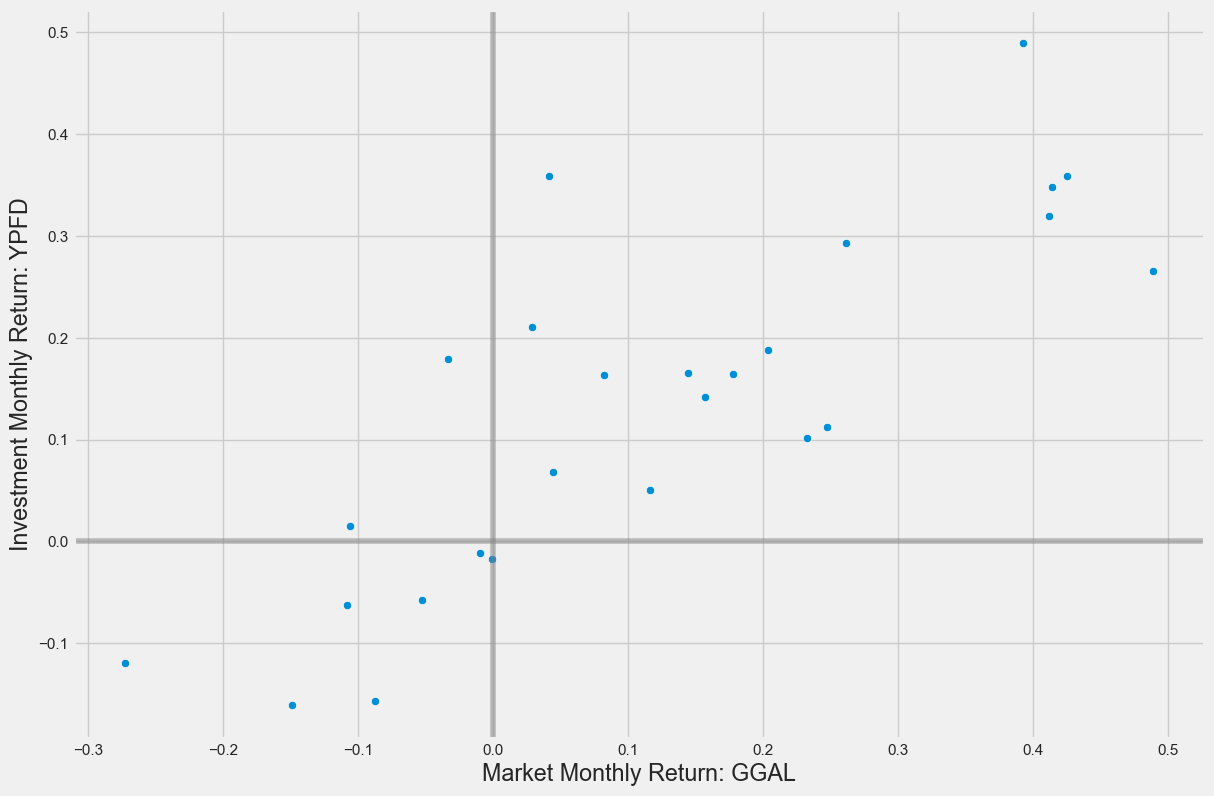

In [112]:
# Crear una figura de tamaño 13x9
plt.figure(figsize=(13, 9))

# Añadir líneas en los ejes X e Y en 0 para referencia
plt.axvline(0, color='grey', alpha=0.5)
plt.axhline(0, color='grey', alpha=0.5)

# Crear un diagrama de dispersión de los retornos
sns.scatterplot(y='Inv_Ret', x='Markt_Ret', data=data)

# Etiquetas de los ejes
plt.xlabel('Market Monthly Return: GGAL')  # 'GGAL' como proxy del mercado
plt.ylabel('Investment Monthly Return: YPFD')  # 'YPFD' como activo individual

# Mostrar el gráfico
plt.show()

Ahora calculamos $\beta$ según la fórmula CAPM:

In [113]:
# Calcular la matriz de covarianza de los retornos
cov_matrix = data[['Inv_Ret', 'Markt_Ret']].cov()

# Calcular la varianza de los retornos del mercado
market_var = data['Markt_Ret'].var()

# Calcular el coeficiente beta usando la fórmula del CAPM
beta_form = (cov_matrix / market_var).iloc[0, 1]

# Mostrar el valor de beta calculado
print('Beta from CAPM formula: ', beta_form.round(4))

Beta from CAPM formula:  0.6979


Ahora, con nuestros datos de rendimiento, hacemos una regresión lineal y calculamos $\alpha$ y $\beta$:

In [114]:
# Realizar la regresión lineal para obtener beta y alpha
beta_reg, alpha = np.polyfit(x=data['Markt_Ret'], y=data['Inv_Ret'], deg=1)

# Imprimir los resultados de beta y alpha
print('Beta from Linear Regression: ', beta_reg.round(4))
print('Alpha: ', alpha.round(3))

Beta from Linear Regression:  0.6979
Alpha:  0.049


Finalmente, trazamos nuestro diagrama de dispersión de rendimientos junto con la línea CAPM:

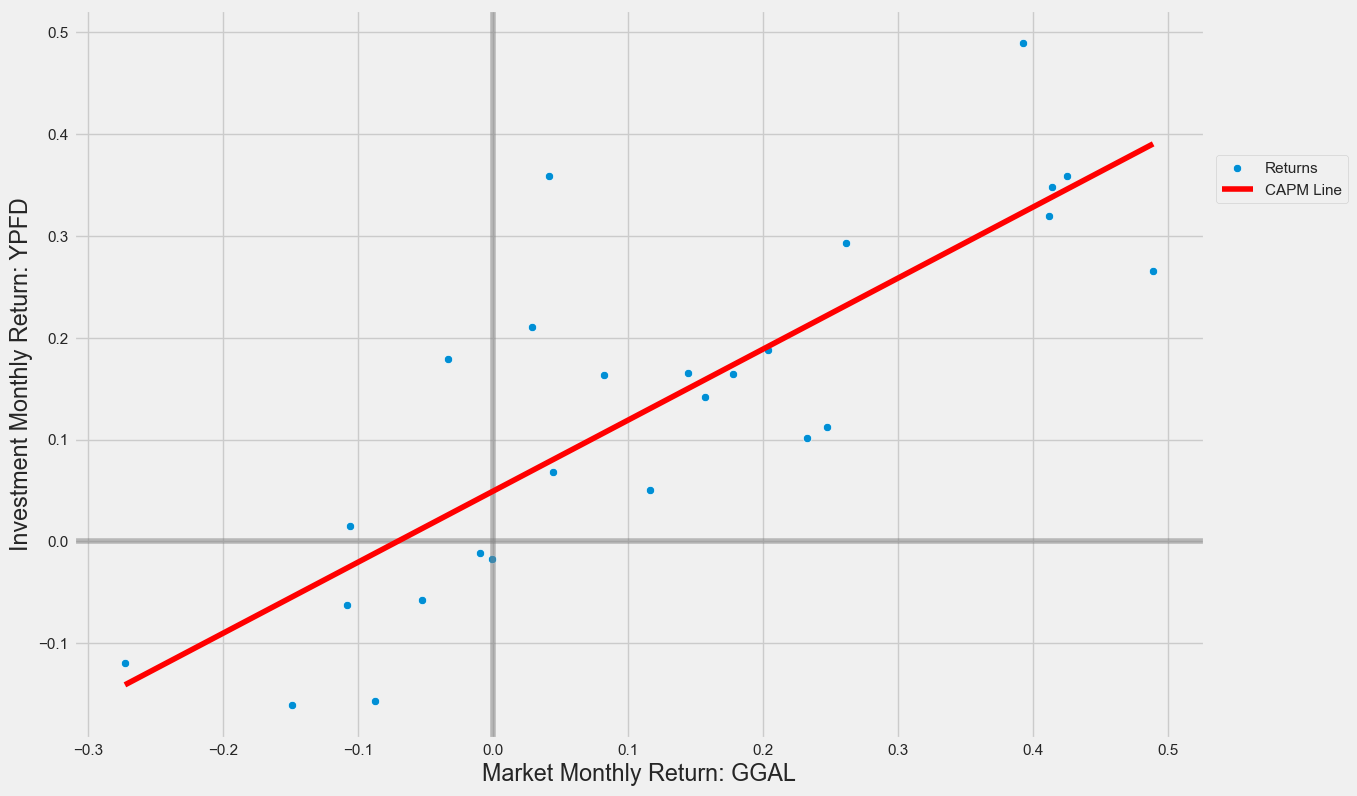

In [115]:
# Crear una figura de tamaño 13x9
plt.figure(figsize=(13, 9))

# Añadir líneas en los ejes X e Y en 0 para referencia
plt.axvline(0, color='grey', alpha=0.5)
plt.axhline(0, color='grey', alpha=0.5)

# Crear un diagrama de dispersión de los retornos
sns.scatterplot(y='Inv_Ret', x='Markt_Ret', data=data, label='Returns')

# Dibujar la línea de CAPM (regresión lineal)
sns.lineplot(x=data['Markt_Ret'], y=alpha + data['Markt_Ret']*beta_reg, color='red', label='CAPM Line')

# Etiquetas de los ejes
plt.xlabel('Market Monthly Return: GGAL')  # 'GGAL' como proxy del mercado
plt.ylabel('Investment Monthly Return: YPFD')  # 'YPFD' como activo individual

# Añadir la leyenda
plt.legend(bbox_to_anchor=(1.01, 0.8), loc=2, borderaxespad=0.)

# Mostrar el gráfico
plt.show()

Ahora definimos una única función que nos da $\alpha$, $\beta$ y el gráfico correspondiente.



Beta from formula:  0.6837
Beta from Linear Regression:  0.6837
Alpha:  0.049


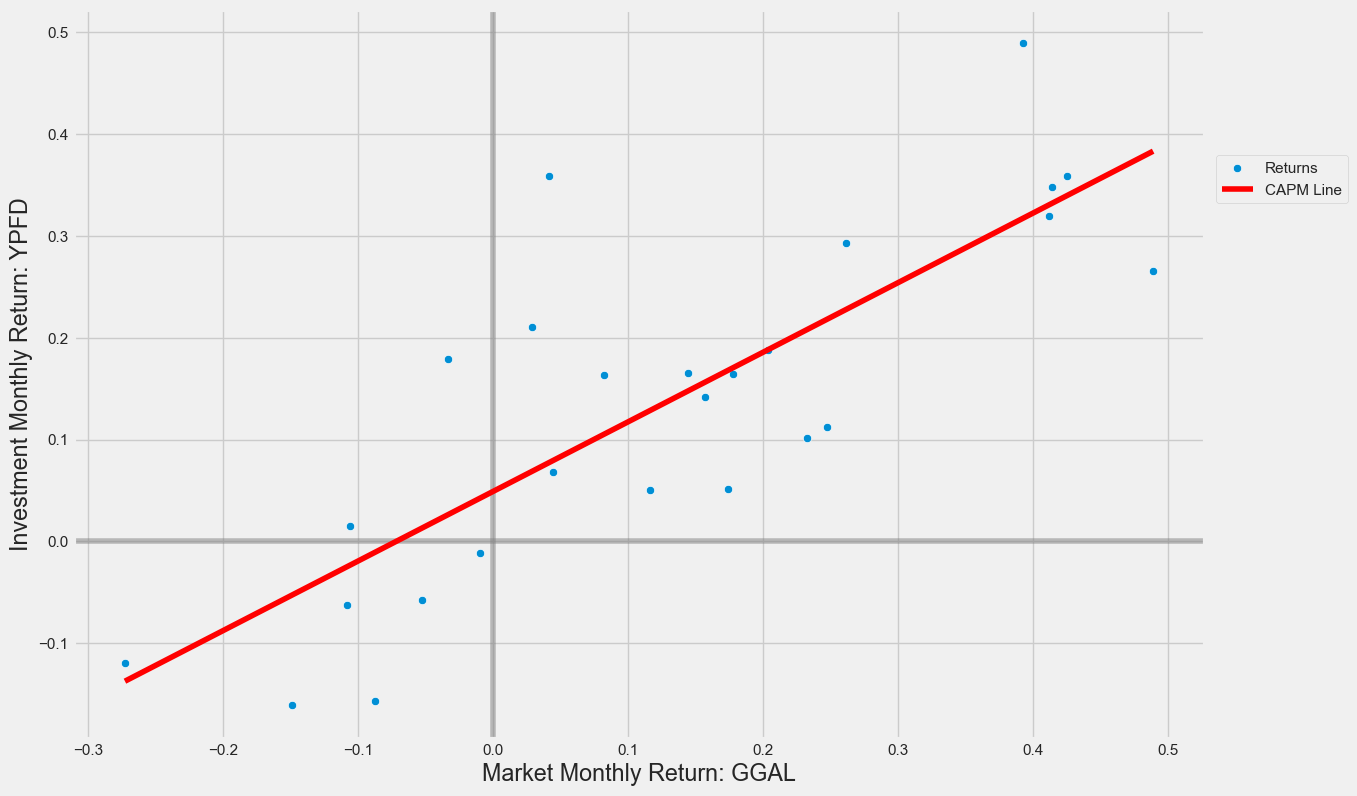

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def CAPM(stock_a_col, stock_m_col, dataframe):
    # Convertir la columna de fecha a índice de fecha para resampling
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe.set_index('Date', inplace=True)
    
    # Obtener los últimos precios de cada mes utilizando 'ME' en lugar de 'M'
    M_stock_a = dataframe[stock_a_col].resample('ME').last()
    M_stock_m = dataframe[stock_m_col].resample('ME').last()

    # Crear un DataFrame con los datos resampleados
    data = pd.DataFrame({'Inv_Close': M_stock_a, 'Markt_Close': M_stock_m})

    # Calcular los retornos logarítmicos de los precios mensuales
    data[['Inv_Ret', 'Markt_Ret']] = np.log(data[['Inv_Close', 'Markt_Close']] / data[['Inv_Close', 'Markt_Close']].shift(1))
    data.dropna(inplace=True)

    # Calcular el coeficiente beta utilizando la fórmula del CAPM
    beta_form = (data[['Inv_Ret', 'Markt_Ret']].cov() / data['Markt_Ret'].var()).iloc[0].iloc[1]

    # Realizar la regresión lineal para obtener beta y alpha
    beta_reg, alpha = np.polyfit(x=data['Markt_Ret'], y=data['Inv_Ret'], deg=1)

    # Imprimir los resultados de beta y alpha
    print('\n')
    print(20 * '==')
    print('Beta from formula: ', beta_form.round(4))
    print('Beta from Linear Regression: ', beta_reg.round(4))
    print('Alpha: ', alpha.round(3))
    print(20 * '==')

    # Crear una figura de tamaño 13x9
    plt.figure(figsize=(13, 9))

    # Añadir líneas en los ejes X e Y en 0 para referencia
    plt.axvline(0, color='grey', alpha=0.5)
    plt.axhline(0, color='grey', alpha=0.5)

    # Crear un diagrama de dispersión de los retornos
    sns.scatterplot(y='Inv_Ret', x='Markt_Ret', data=data, label='Returns')

    # Dibujar la línea de CAPM (regresión lineal)
    sns.lineplot(x=data['Markt_Ret'], y=alpha + data['Markt_Ret'] * beta_reg, color='red', label='CAPM Line')

    # Etiquetas de los ejes
    plt.xlabel(f'Market Monthly Return: {stock_m_col}')
    plt.ylabel(f'Investment Monthly Return: {stock_a_col}')

    # Añadir la leyenda
    plt.legend(bbox_to_anchor=(1.01, 0.8), loc=2, borderaxespad=0.)

    # Mostrar el gráfico
    plt.show()

# Llamar a la función con las columnas deseadas del dataframe
CAPM('YPFD', 'GGAL', df)

Lo intentamos con YPF:

In [ ]:
stock_a = ['YPFD'] 
stock_m = ['GGAL']  

start = pd.to_datetime('2022-06-30')
end = pd.to_datetime('2024-08-23')

CAPM(stock_a,stock_m,start, end)

Lo intentamos con Banco Macro:

In [ ]:
stock_a = ['BMA'] 
stock_m = ['GGAL']  

start = pd.to_datetime('2022-06-30')
end = pd.to_datetime('2024-08-23')

CAPM(stock_a,stock_m,start, end)

Lo intentamos con Pampa Energía:

In [ ]:
stock_a = ['PAMP'] 
stock_m = ['GGAL']  

start = pd.to_datetime('2022-06-30')
end = pd.to_datetime('2024-08-23')

CAPM(stock_a,stock_m,start, end)

Para completar, podemos construir una función similar, ahora teniendo en cuenta los rendimientos diarios en lugar de mensuales.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def CAPM_daily(stock_a_col, stock_m_col, dataframe):
    # Convertir la columna de fecha a índice de fecha para cálculos diarios
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe.set_index('Date', inplace=True)
    
    # Obtener los precios de cierre diarios directamente
    data_a = dataframe[stock_a_col]
    data_m = dataframe[stock_m_col]

    # Crear un DataFrame con los datos de precios diarios
    data = pd.DataFrame({'Inv_Close': data_a, 'Markt_Close': data_m})

    # Calcular los retornos logarítmicos de los precios diarios
    data[['Inv_Ret', 'Markt_Ret']] = np.log(data[['Inv_Close', 'Markt_Close']] / data[['Inv_Close', 'Markt_Close']].shift(1))
    data.dropna(inplace=True)

    # Calcular el coeficiente beta utilizando la fórmula del CAPM
    beta_form = (data[['Inv_Ret', 'Markt_Ret']].cov() / data['Markt_Ret'].var()).iloc[0].iloc[1]

    # Realizar la regresión lineal para obtener beta y alpha
    beta_reg, alpha = np.polyfit(x=data['Markt_Ret'], y=data['Inv_Ret'], deg=1)

    # Imprimir los resultados de beta y alpha
    print('\n')
    print(20 * '==')
    print('Beta from formula: ', beta_form.round(4))
    print('Beta from Linear Regression: ', beta_reg.round(4))
    print('Alpha: ', alpha.round(3))
    print(20 * '==')

    # Crear una figura de tamaño 13x9
    plt.figure(figsize=(13, 9))

    # Añadir líneas en los ejes X e Y en 0 para referencia
    plt.axvline(0, color='grey', alpha=0.5)
    plt.axhline(0, color='grey', alpha=0.5)

    # Crear un diagrama de dispersión de los retornos
    sns.scatterplot(y='Inv_Ret', x='Markt_Ret', data=data, label='Returns')

    # Dibujar la línea de CAPM (regresión lineal)
    sns.lineplot(x=data['Markt_Ret'], y=alpha + data['Markt_Ret'] * beta_reg, color='red', label='CAPM Line')

    # Etiquetas de los ejes
    plt.xlabel(f'Market Daily Return: {stock_m_col}')
    plt.ylabel(f'Investment Daily Return: {stock_a_col}')

    # Añadir la leyenda
    plt.legend(bbox_to_anchor=(1.01, 0.8), loc=2, borderaxespad=0.)

    # Mostrar el gráfico
    plt.show()

# Llamar a la función con las columnas deseadas del dataframe
CAPM_daily('YPFD', 'GGAL', df)

KeyError: 'Date'

Lo intentamos con YPF:

In [ ]:
stock_a = ['YPFD'] 
stock_m = ['GGAL']  

start = pd.to_datetime('2022-06-30')
end = pd.to_datetime('2024-08-23')

CAPM_daily(stock_a,stock_m,start, end)

A partir de esto, notamos un cambio cuantitativo en la estimación de Beta.